# Image Paraphrasing

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
import tensorflow as tf
import numpy as np
from time import time
import matplotlib.pyplot as plt
% matplotlib inline
import cv2
from scipy.misc import imsave
# from utils import receptive_field_computer
nsample = 16
from utils import *
import itertools
from neural_style import build_model
# from models_bedroom import *
from nets import *

ntimes = 16
nimages = 40

# Hyperparameter for Part Change
SHOW_IMAGE = False
npx_list = [64]
# lr_list = [8e-3 * 2**i for i in range(-6,7)]
lr_list = [9e-2] # For adam
# lr_list = [1e3] # For sgd [1e3] or [1e2]
max_step_list = [1000]
main_coef_list = [1.]
mask_pos_list = [None]
mask_prob_list = [0.5]
b1 = 0.4
b2 = 0.99
# b1=0.1
# b2=0.1


# Discriminator 
alpha_list = [0.]

# Pixel Space
gamma_list = [0.]#[0.1/255.]

noise_coef_list =  [0.]
content_layers_list = [['relu%d_%d'%(4,1),'relu%d_%d'%(5,1)]] 
# content_layers_list = [['relu%d_%d'%(1,1)],['relu%d_%d'%(2,1)],['relu%d_%d'%(3,1)],['relu%d_%d'%(4,1)],['relu%d_%d'%(5,1)]] 
#content_layers_list = [['relu%d_%d'%(1,1),'relu%d_%d'%(2,1),'relu%d_%d'%(3,1),'relu%d_%d'%(4,1),'relu%d_%d'%(5,1),'input_masked'] ] 

# content_weights_list = [[5., 1.]]
content_weights_list = [[1.]]
# content_weights_list = [[0., 1., 0., 1., 0., 0.]]


# content_types_list = [['Feature','Feature']]
content_types_list = [['Feature']]

# mask_types_list = [['main', 'comp']]
mask_types_list = [['main']]
# content_types_list = [['Feature', 'Feature', 'Feature', 'Feature', 'Feature', 'Feature']]
# content_layers_list = [['conv%d_%d'%(1,2),'conv%d_%d'%(2,2),'conv%d_%d'%(3,1), 'conv%d_%d'%(4,1), 'conv%d_%d'%(5,1)] ] 
# CONTENT_LOSS_TYPE = 'Gram'

hyper_lists=[npx_list
           ,lr_list
           ,max_step_list
           ,main_coef_list
           ,mask_pos_list
           ,alpha_list
           ,gamma_list
           ,noise_coef_list
           ,content_layers_list
           ,content_weights_list
           ,content_types_list
           ,mask_prob_list
           ,mask_types_list
            ]
result_path = 'Results_sgd'
Dataset = 'CelebA'
# n_list = [str(i) for i in np.random.randint(10000, size=1)]
# n_list = ['0001256'] #Red bed

# content_img_paths = ['../BEGAN-tensorflow/data/Bedroom/splits/train/%s.jpg'%n.zfill(7) for n in n_list]
if Dataset == 'Bedroom':
#     n_list = ['4596']
    n_list = [str(i) for i in np.random.randint(50000, size=nimages)]
    content_img_paths = ['/home/tim/kjliu/project-file/data/Bedroom/splits/test/%s.jpg'%n.zfill(7) for n in n_list]
elif Dataset == 'CelebA':
    n_list = [str(i) for i in np.random.randint(19962, size=nimages)]
#     n_list = ['870'] #['23245]
#     content_img_paths = ['/home/tim/kjliu/project-file/data/CelebA/splits/train/%s.jpg'%n.zfill(6) for n in n_list]
    content_img_paths = ['/home/tim/kjliu/project-file/data/CelebA/splits/test/%s.jpg'%n.zfill(6) for n in n_list]   



In [2]:
def assign_hyperparameter(hyperparameters, root_path):
    global npx, lr, max_step, main_coef, mask_pos, mask, prob, gram_mask
    global alpha, recon_mask
    global gamma, pixel_mask
    global noise_coef
    global content_layers, content_weights, content_types
    global mask_types
    global b1, b2
    # Hyperparameter for Part Change
    npx = hyperparameters[0]
    lr = hyperparameters[1]
    max_step = hyperparameters[2]
    main_coef = hyperparameters[3]
    mask_pos = hyperparameters[4]
    
    


    noise_coef =  np.sqrt(lr) * hyperparameters[7]
    content_layers = hyperparameters[8]
    content_weights = hyperparameters[9]
    content_types = hyperparameters[10]
    prob = hyperparameters[11]
    
    mask = 1#-gen_mask(npx, (32,29), blur = 1, prob = 1., rect_size = (30,30)).reshape(npx,npx,1)
    #mask = gen_mask(npx, mask_pos, blur = 10, prob = prob).reshape(npx,npx,1)
    
    # Discriminator 
    alpha = hyperparameters[5]      
    recon_mask = 1 if mask_pos is None else (1-mask)

    # Pixel Space
    gamma = hyperparameters[6]
    pixel_mask = 1 - mask
    
    mask_types = hyperparameters[12]
    with open(os.path.join(root_path, 'hyperparameters.txt'), 'w') as f:
        f.write('npx: %d\n'%npx)
        f.write('lr: %.3E\n'%lr)
        f.write('max_step: %d\n'%max_step)
        f.write('main_coef: %.3E\n'%main_coef)
        f.write('mask_pos: %s\n'%(mask_pos, ))
        f.write('alpha: %.3E\n'%alpha)
        f.write('gamma: %.3E\n'%gamma)
        f.write('noise_coef: %.3E\n'%noise_coef)
        f.write('content_layers: %s\n'%content_layers)
        f.write('content_weights: %s\n'%content_weights)
        f.write('content_types: %s\n'%content_types)
        f.write('mask_prob: %s\n'%prob)
        f.write('beta1: %s\n'%b1)
        f.write('beta2: %s\n'%b2)

## Check reference image

(64, 64, 3)


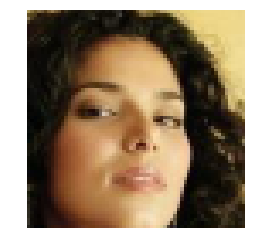

In [3]:
img = read_img(content_img_paths[0])
print(img.shape)
plot_img(img/255.)

## Load corresponding model architecture
- WGAN for Bedroom
- BEGAN for CelebA

In [4]:

if Dataset == 'Bedroom':
    from gan_64x64 import GeneratorAndDiscriminator
    import tflib as lib
elif Dataset == 'CelebA':
    from models_celeba_began import *
# lib.delete_all_params()
# print(lib._params, lib._param_aliases)

In [5]:
# n = [op.name for op in tf.get_default_graph().get_operations() ]
# print(n)

## Optimization main part

Hyperparameters: (64, 1000.0, 1000, 1.0, None, 0.0, 0.0, 0.0, ['relu4_1', 'relu5_1'], [1.0], ['Feature'], 0.5, ['main'])


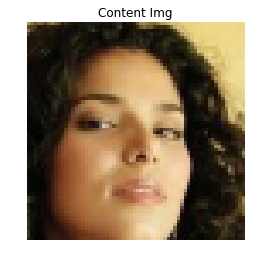

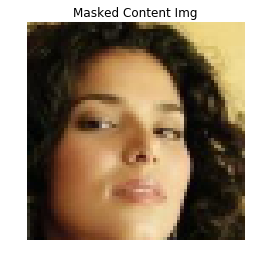

INFO:tensorflow:Restoring parameters from logs/CelebA_0517_071609/model.ckpt-657034
Cost time: 1.05s
['relu4_1', 'relu5_1'] [1.0] ['Feature'] ['main']
Layer: relu4_1, Feature, 1, main
Instructions for updating:
Use `tf.variables_initializer` instead.


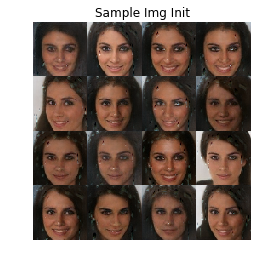

  0%|          | 0/1000 [00:00<?, ?it/s]

At iterate 0	f=  0.0346


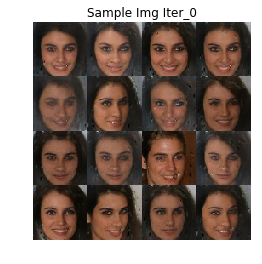

 10%|█         | 100/1000 [00:22<03:08,  4.77it/s]

At iterate 100	f=  0.0283


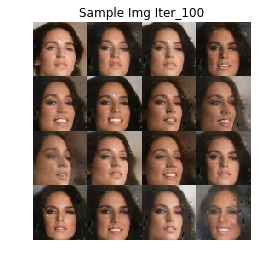

 20%|██        | 200/1000 [00:43<02:49,  4.73it/s]

At iterate 200	f=  0.0294


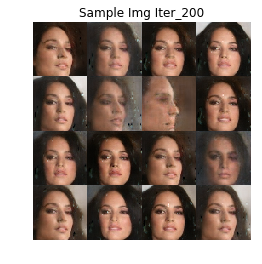

 30%|███       | 300/1000 [01:04<02:27,  4.74it/s]

At iterate 300	f=  0.0295


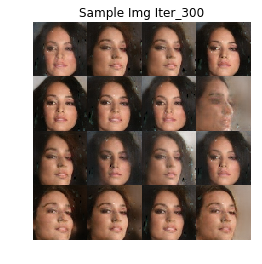

 40%|████      | 400/1000 [01:26<02:07,  4.69it/s]

At iterate 400	f=  0.0296


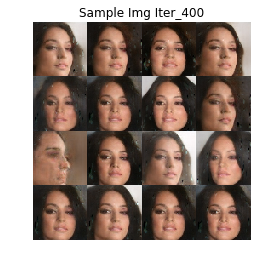

 50%|█████     | 500/1000 [01:47<01:47,  4.66it/s]

At iterate 500	f=  0.0295


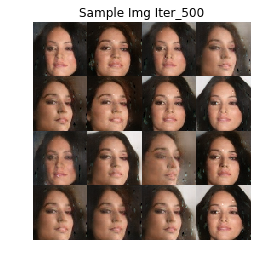

 60%|██████    | 600/1000 [02:09<01:24,  4.72it/s]

At iterate 600	f=  0.0286


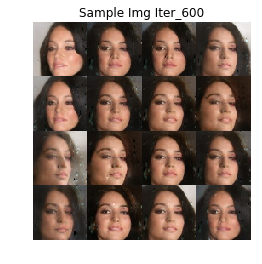

 70%|███████   | 700/1000 [02:30<01:04,  4.67it/s]

At iterate 700	f=  0.0303


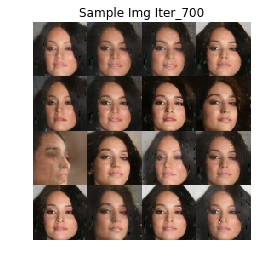

 80%|████████  | 800/1000 [02:52<00:42,  4.67it/s]

At iterate 800	f=  0.0269


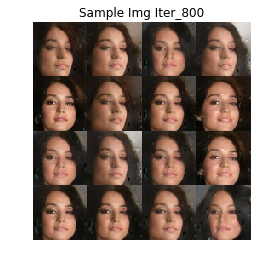

 90%|█████████ | 900/1000 [03:13<00:21,  4.67it/s]

At iterate 900	f=  0.0292


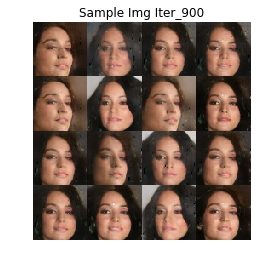

100%|██████████| 1000/1000 [03:35<00:00,  4.69it/s]

At iterate 999	f=  0.0292


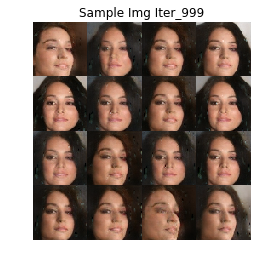

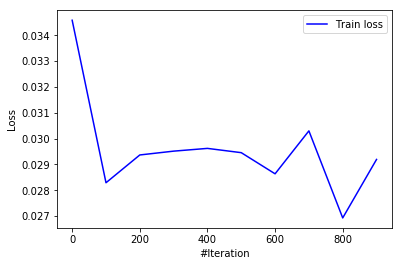

Final loss: 0.0292


In [6]:


for idx, hyperparameters in enumerate(itertools.product(*hyper_lists)):
#     for i in range(100):
    print('Hyperparameters: %s'%(hyperparameters,))
    ########################### Prepare Experiment ###########################
    root_path = os.path.join(result_path, Dataset + '_' + get_time())
    mkdir(root_path)
    assign_hyperparameter(hyperparameters, root_path)

    ########################### Load Content Image ###########################
    if len(content_img_paths) > 1:
        content_img = read_imgs(content_img_paths, npx) 
    else:
        content_img = read_img(content_img_paths[0], npx)
    content_img_orig = content_img.copy()
    #content_img = content_img.reshape(-1,npx,npx,3)
    content_img = preprocess(content_img, npx = npx)

    if len(content_img_paths) > 1:
        content_img_orig_grid = color_grid_vis(content_img_orig)
        plot_img(content_img_orig_grid/255., title='Content Img', save_path=os.path.join(root_path, 'content_img_original.jpg'))
    else:
        content_img_orig_grid = content_img_orig
        plot_img(content_img_orig/255., title='Content Img', save_path=os.path.join(root_path, 'content_img_original.jpg'))
        plot_img(content_img_orig * mask / 255., title='Masked Content Img', save_path=os.path.join(root_path, 'masked_ContImg.jpg'))
    
    

    ########################### Build Graph ###########################
    if Dataset == 'Bedroom':
        with tf.variable_scope('Paraphrasing') as scope:
        #     scope.reuse_variables()
            paint_board = tf.get_variable('Paint_board', [nsample, 128],initializer=tf.random_normal_initializer())
        init_op_paint_board = tf.variables_initializer([paint_board])
        generator, discriminator = GeneratorAndDiscriminator()
        init_img_orig = generator(nsample, noise=paint_board)
        init_img = tf.transpose(tf.reshape(init_img_orig, [-1,3, 64,64]), [0,2,3,1])
        init_img = tf.image.resize_nearest_neighbor(init_img, [npx, npx])
        init_img = (init_img + 1)/2 * 255.
        init_img_vgg = init_img
        init_img_vgg = vgg_img(init_img)

        init_img_logits = discriminator(init_img_orig)
        g_vars = tf.contrib.framework.get_variables('Generator')
        d_vars = tf.contrib.framework.get_variables('Discriminator')
        var = g_vars + d_vars
        net = build_model(content_img, mask = tf.constant(mask, dtype=tf.float32))
    #     net = build_model(vgg_img(content_img), mask = tf.constant(mask, dtype=tf.float32))
        net2 = build_model(init_img_vgg, is_gen=True, mask = tf.constant(mask, dtype=tf.float32))
        net3 = build_model(content_img, mask = tf.constant(pixel_mask, dtype=tf.float32))
        net4 = build_model(init_img_vgg, is_gen=True, mask = tf.constant(pixel_mask, dtype=tf.float32))
    elif Dataset == 'CelebA':
        with tf.variable_scope('Paraphrasing') as scope:
            paint_board = tf.get_variable('Paint_board', [nsample, 64],initializer=tf.random_uniform_initializer())
        init_op_paint_board = tf.variables_initializer([paint_board])

        init_img_orig, g_vars = GeneratorCNN(paint_board,128,3,4,'NCHW',reuse=False)
        init_img = tf.transpose(init_img_orig, [0,2,3,1])
        init_img = tf.image.resize_nearest_neighbor(init_img, [npx, npx])
        init_img = (init_img + 1)/2 * 255.
        init_img_vgg = vgg_img(init_img)

        init_img_recon,_, d_vars = DiscriminatorCNN(init_img_orig,3,64,4,128,'NCHW')

        var = g_vars + d_vars

        net = build_model(content_img, mask = tf.constant(mask, dtype=tf.float32))
        net2 = build_model(init_img_vgg, is_gen=True, mask = tf.constant(mask, dtype=tf.float32))
        net3 = build_model(content_img, mask = tf.constant(pixel_mask, dtype=tf.float32))
        net4 = build_model(init_img_vgg, is_gen=True, mask = tf.constant(pixel_mask, dtype=tf.float32))
    ########################### Loss ###########################
    from time import time
    t = time()
    sess = tf.Session()
    saver = tf.train.Saver(var)
    
    
    if Dataset == 'CelebA':
        saver.restore(sess, tf.train.latest_checkpoint('logs/CelebA_0517_071609/'))
    #elif Dataset == 'Bedroom': # Wrong model(with Batchnorm)
    #    saver.restore(sess, tf.train.latest_checkpoint('logs/Bedroom_0726_161928/'))
    elif Dataset == 'Bedroom':
        saver.restore(sess, tf.train.latest_checkpoint('logs/Bedroom_0812_011108/'))
    print("Cost time: %.2fs"%(time() - t))

    # content loss
    L_content, loss_collections = sum_content_losses(sess, net, net2, net3, net4,
                                                     content_img,
                                                     content_layers=content_layers,
                                                     content_layer_weights=content_weights,
                                                     content_types = content_types,
                                                     mask_types = mask_types
                                                    )

    # Discrim loss
    if Dataset == 'CelebA':
        discrim_loss = tf.reduce_mean(tf.abs(init_img_recon - init_img_orig) )
    elif Dataset == 'Bedroom':
        discrim_loss = - tf.reduce_mean(init_img_logits)

    # total loss
    L_total  = main_coef * L_content
    alpha_var = tf.get_variable(name='alpha', dtype=tf.float32, initializer=alpha * 1.0)
    L_total += alpha_var*discrim_loss
    L_total += gamma*tf.reduce_mean(tf.abs(content_img_orig - init_img)*tf.constant((pixel_mask),dtype=tf.float32))
    
    ############################ optimization algorithm ###############################
    init_z = paint_board



    with tf.variable_scope('adam_optimizer') as vs:
        optimizer = tf.train.AdamOptimizer(lr, beta1=b1, beta2=b2)
        #optimizer = tf.train.GradientDescentOptimizer(lr)
#         optimizer = tf.train.RMSPropOptimizer(lr)

        gvs = optimizer.compute_gradients(L_total, var_list=[init_z])
        gvs = [(grad+noise_coef*tf.random_normal(tf.shape(grad)), var) for grad, var in gvs]

        train_op = optimizer.apply_gradients(gvs)
        vars = tf.contrib.framework.get_variables(vs)
    init_op = tf.initialize_variables(vars + [alpha_var])    

    ########################### Session Run ###########################
    output_data = []
    for t in range(ntimes):
        sess.run(init_op_paint_board)
        sess.run(init_op)
        i = sess.run(init_img)
        grid_imgs = color_grid_vis(i)
        rand = str(np.random.randint(10000))
        plot_img(my_post(grid_imgs), title='Sample Img Init', save_path=os.path.join(root_path, 'samples_init.jpg'))
        train_loss = []
        for iterations in trange(max_step):
            sess.run(train_op)
            if iterations % 100 == 0:
                curr_loss = sess.run(L_total)
                train_loss.append(curr_loss)
                img = sess.run(init_img)
                grid_imgs = color_grid_vis(img)

                print("At iterate {}\tf=  {:.4f}".format(iterations, curr_loss))
    #             loss = sess.run(loss_collections)
    #             print(loss)
                plot_img(my_post(grid_imgs), title='Sample Img Iter_%d'%iterations, save_path=os.path.join(root_path, 'samples_iter_%d.png'%iterations))
            if iterations > 99:
                if iterations % 100 == 0:
                    alpha_var.assign(sess.run(alpha_var) * 1)
        img = sess.run(init_img)
        output_data.append(img)
        grid_imgs = color_grid_vis(img)

        print("At iterate {}\tf=  {:.4f}".format(iterations, curr_loss))
        plot_img(my_post(grid_imgs), title='Sample Img Iter_%d'%iterations, save_path=os.path.join(root_path, 'samples_iter_%d.png'%iterations))

        ########################### Plot final learning result & write to file #####################
        plt.plot(np.arange(len(train_loss)) * 100, train_loss, color='blue', label='Train loss')
        plt.legend(loc="upper right")
        plt.xlabel('#Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('Final loss: %.4f'%train_loss[-1])
        with open(os.path.join(root_path, 'hyperparameters.txt'), 'a') as f:
            f.write('Final loss: %d\n'%train_loss[-1])
    ########################### Close Session & Reset Graph
    tf.reset_default_graph()
    #sess.close()
    if Dataset == 'Bedroom':
        lib.delete_all_params()


## Evaluation 

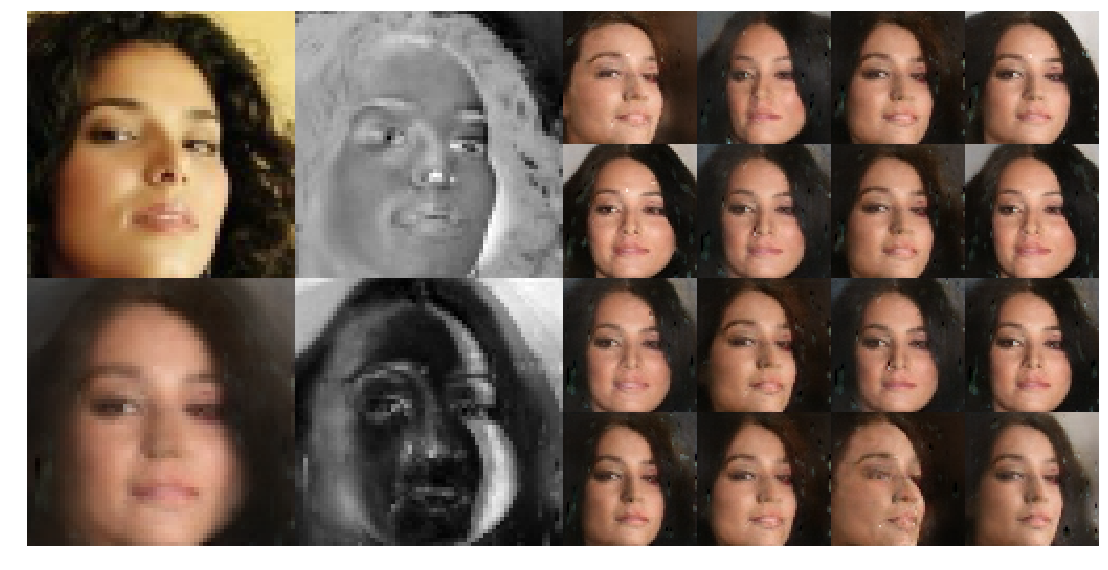

In [7]:
plot_result(content_img_orig, img, save_path = os.path.join(root_path,'results.png'))

In [1]:
print(img.shape)

NameError: name 'img' is not defined

In [8]:
# !python msssim_Copy1.py --original_image=187628.jpg --compared_image=187627.jpg

In [9]:
# !python msssim.py --path=./ --nsamples=1
